In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import keras
from keras import layers
from tensorflow import convert_to_tensor
sns.set_style("whitegrid")

In [62]:
aggregate=pd.read_csv('./aggregate.csv',engine='python')
aggregate.set_index('GEO_ID',inplace=True)
agg_train, agg_test = train_test_split(aggregate,test_size=0.2,shuffle=True,random_state=121) # Split dataset into 80%-20% training and testing, random_state=121 for consistency

#Construct extra features for use in the models
agg_train['unemp_bac']=agg_train['unemp_rate']*agg_train['bac_deg']
agg_train['log_pop']=np.log10(agg_train['total_pop'].apply(lambda x: max(x,0.1)))
agg_train['log_urban_pop']=np.log10((agg_train['urban']*agg_train['total_pop']).apply(lambda x: max(x,0.1)))
for x in agg_train.index:
    agg_train.loc[x,'winner'] = 'D' if agg_train.loc[x,'democrat'] > agg_train.loc[x,'republican'] else 'R' #For classifer problems: determine winner in each county

features=['white_pc','urban', 'unemp_bac', 'log_pop','log_urban_pop','pov_pc', 'unemp_rate', 'bac_deg', 'hs_deg', 'pop_18_30_pc', 'pop_60_up_pc'] #list of features we want to use
results=['democrat','republican']
target='democrat' #target variable, 'republican'=100-'democrat' approximately

In [69]:
kfold=KFold(n_splits=5,shuffle=True,random_state=121)
mse=0
r2=0
for train_i, test_i in kfold.split(agg_train):
    train_var = agg_train.iloc[train_i]
    test_var = agg_train.iloc[test_i]
    x_tt=convert_to_tensor(train_var[features])
    y_tt=convert_to_tensor(train_var[target])
    x_test=convert_to_tensor(test_var[features])
    y_test=convert_to_tensor(test_var[target])
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01, #initial learning rate
    decay_steps= 1000 ,
    decay_rate=0.95)

#We use two layers of size 15 each
    model = keras.Sequential([
    layers.InputLayer(len(features)),
    layers.BatchNormalization(axis = -1),
    layers.Dense(15, activation = 'relu'),
    layers.Dense(15, activation = 'relu'),
    layers.Dense(1,kernel_regularizer=keras.regularizers.L2(0.01))
    ])
    model.compile(keras.optimizers.legacy.Adam(learning_rate=lr_schedule), loss = "mse", metrics= [keras.metrics.RootMeanSquaredError()])
    history = model.fit(x_tt, y_tt, epochs = 200, validation_data = (x_test, y_test), batch_size = 32) 
    mse+=mean_squared_error(model.predict(x_test), y_test)
    r2+=r2_score(model.predict(x_test),y_test)
mse=mse/5

Epoch 1/200
63/63 [==============================] - 1s 3ms/step - loss: 535.0834 - root_mean_squared_error: 23.1311 - val_loss: 1009.9069 - val_root_mean_squared_error: 31.7784
Epoch 2/200
63/63 [==============================] - 0s 2ms/step - loss: 111.4814 - root_mean_squared_error: 10.5565 - val_loss: 211.4115 - val_root_mean_squared_error: 14.5386
Epoch 3/200
63/63 [==============================] - 0s 2ms/step - loss: 100.5075 - root_mean_squared_error: 10.0233 - val_loss: 147.8793 - val_root_mean_squared_error: 12.1589
Epoch 4/200
63/63 [==============================] - 0s 1ms/step - loss: 95.2247 - root_mean_squared_error: 9.7562 - val_loss: 104.2905 - val_root_mean_squared_error: 10.2103
Epoch 5/200
63/63 [==============================] - 0s 2ms/step - loss: 91.4927 - root_mean_squared_error: 9.5631 - val_loss: 75.1928 - val_root_mean_squared_error: 8.6691
Epoch 6/200
63/63 [==============================] - 0s 2ms/step - loss: 89.9180 - root_mean_squared_error: 9.4804 - val

In [70]:
print(mse,r2/5)

68.44528549245231 0.6351408643944746


16/16 [==============================] - 0s 962us/step


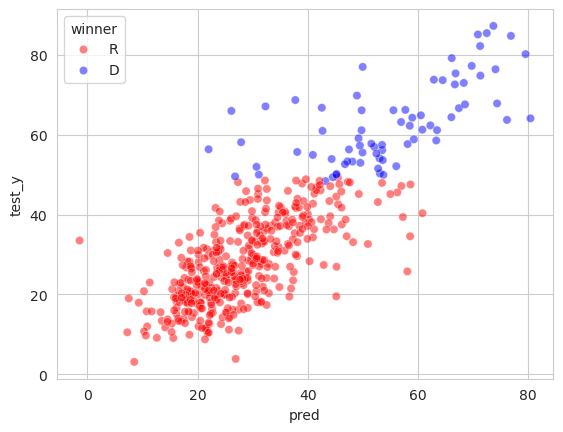

In [71]:
#Example chart
pred=pd.DataFrame({'pred':model.predict(test_var[features]).flatten(),'test_y':test_var['democrat'].values,'winner':test_var['winner'].values})
sns.scatterplot(data=pred,x='pred',y='test_y',hue='winner',palette=['red','blue'], alpha=0.5)
plt.show()